**Student Name:**    Xing Yang Goh

**Student ID:**     1001969

This iPython notebook is a template which you should use for your Assignment 3 submission. This file should be submitted at the **Assignment 3: Code** link on the LMS, along with any images needed to run your code.

In addition to this file, you should submit a writren report explaining your results at the **Assignment 3: Report** link on the LMS. Please see the assignment specification for details on what must be included in the report for each question.

*Adding proper comments to your code is MANDATORY.*

In [125]:
# Import Packages
import os
import numpy as np
import cv2
import glob
import matplotlib.pyplot as plt
import random
from scipy.linalg import null_space

### 1. Load images and compute correspondences


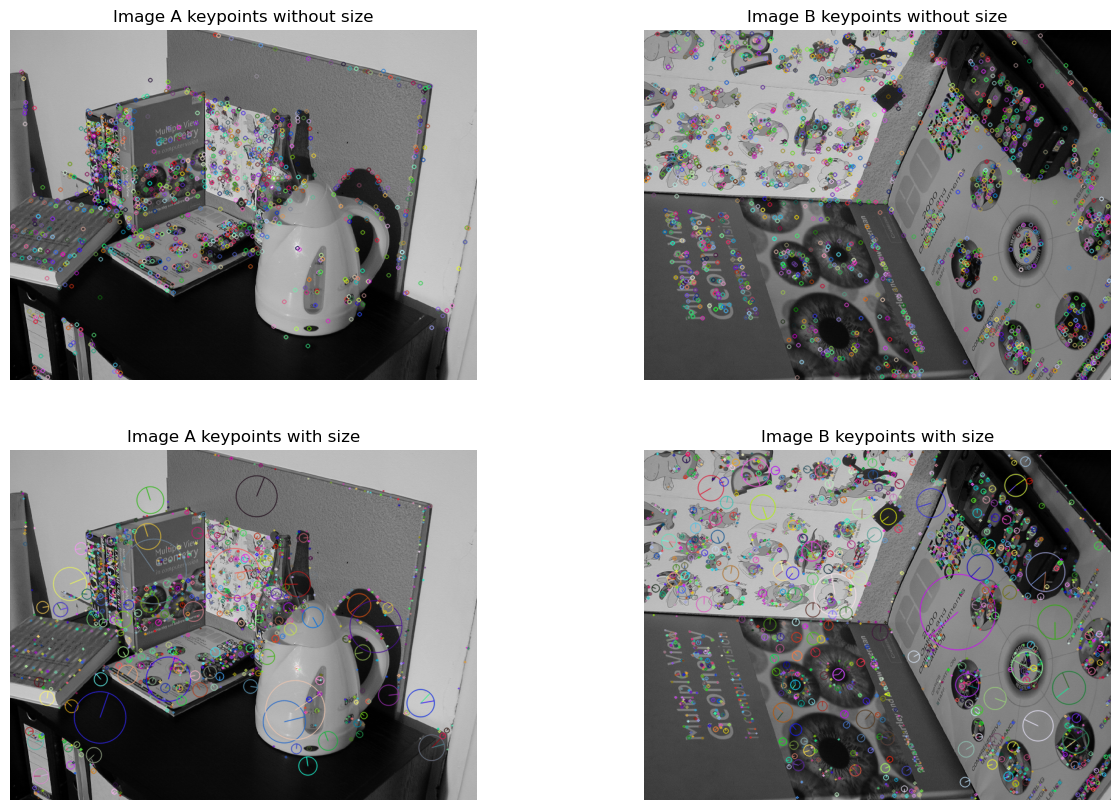

Number of keypoints detected in the Image A:  1265
Number of keypoints detected in the Image B:  2182


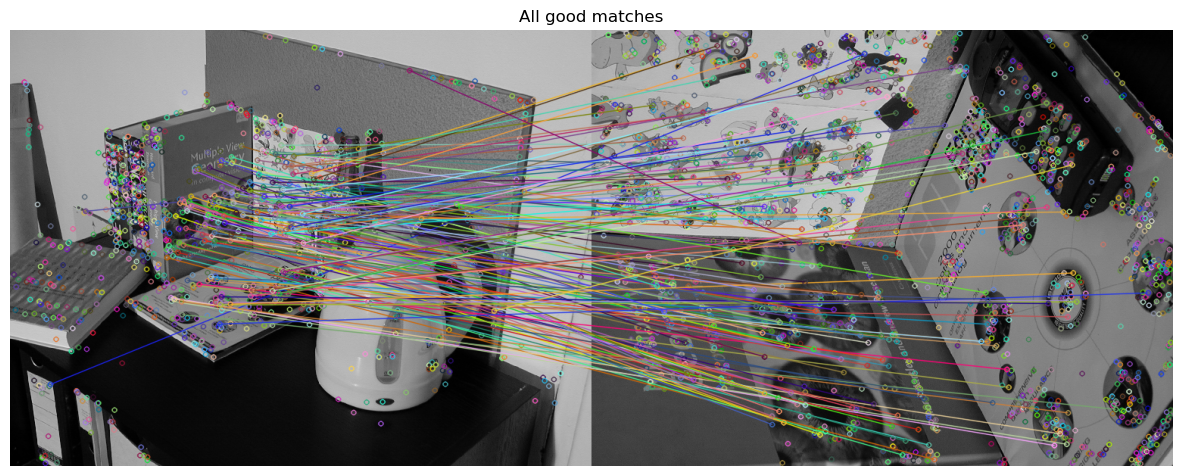


Number of good matches between two images:  141


In [126]:
# Read in images from a filepath as graycsale.
rootpath='./kusvod2'
imgA = cv2.imread(os.path.join(rootpath, 'bookshA.png'),cv2.IMREAD_GRAYSCALE)
imgB = cv2.imread(os.path.join(rootpath, 'bookshB.png'),cv2.IMREAD_GRAYSCALE)

# Initiate SIFT detector
sift = cv2.SIFT_create()

# Compute SIFT keypoints and descriptors
kp1, des1 = sift.detectAndCompute(imgA,None)
kp2, des2 = sift.detectAndCompute(imgB,None)

# Draws the small circles on the locations of keypoints without size
kp1_without_size = cv2.drawKeypoints(imgA,kp1,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )
kp2_without_size = cv2.drawKeypoints(imgB,kp2,None
                                     #, color = (0, 0, 255) #If you want a specific colour
                                    )

# Draws a circle with the size of each keypoint and show its orientation
kp1_with_size = cv2.drawKeypoints(imgA,kp1,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)
kp2_with_size = cv2.drawKeypoints(imgB,kp2,None,flags=cv2.DRAW_MATCHES_FLAGS_DRAW_RICH_KEYPOINTS)

# Display images with&without the size of keypoints 
plt.subplots(figsize=(15, 10)) 

plt.subplot(2,2,1)
plt.imshow(kp1_without_size, cmap='gray')  
plt.title('Image A keypoints without size')
plt.axis('off')

plt.subplot(2,2,2)
plt.imshow(kp2_without_size, cmap='gray')  
plt.title('Image B keypoints without size')
plt.axis('off')

plt.subplot(2,2,3)
plt.imshow(kp1_with_size, cmap='gray')  
plt.title('Image A keypoints with size')
plt.axis('off')

plt.subplot(2,2,4)
plt.imshow(kp2_with_size, cmap='gray')  
plt.title('Image B keypoints with size')
plt.axis('off')

plt.show() 

# Print the number of keypoints detected
print("Number of keypoints detected in the Image A: ", len(kp1))
print("Number of keypoints detected in the Image B: ", len(kp2))

# FLANN parameters and initialize
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm = FLANN_INDEX_KDTREE, trees = 5)
search_params = dict(checks=50)   # or pass empty dictionary
flann = cv2.FlannBasedMatcher(index_params,search_params)

# Matching descriptor using KNN algorithm
matches = flann.knnMatch(des1,des2,k=2)

# Create a mask to draw all good matches
matchesMask = []

# Store all good matches as per Lowe's Ratio test.
good = []
pts1 = []
pts2 = []
for m,n in matches:
    if kp1[m.queryIdx].pt in pts1 or kp2[m.trainIdx].pt in pts2:
        matchesMask.append([0,0])
        continue;
        
    if m.distance < 0.7*n.distance:
        good.append(m)
        pts2.append(kp2[m.trainIdx].pt)
        pts1.append(kp1[m.queryIdx].pt)
        
        matchesMask.append([1,0]) # Match
    else:
        matchesMask.append([0,0]) # Mismatch
       
    
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)

# Draw all good matches
draw_params = dict(#matchColor = (0,255,0),  #If you want a specific colour
                   #singlePointColor = (255,0,0), #If you want a specific colour
                    matchesMask = matchesMask,
                    flags = cv2.DrawMatchesFlags_DEFAULT)

good_matches = cv2.drawMatchesKnn(imgA,kp1,imgB,kp2,matches,None,**draw_params)


plt.figure(figsize=(15, 15))

plt.imshow(good_matches)
plt.title('All good matches')
plt.axis('off')

plt.show()

# Print total number of good matches between two images
print("\nNumber of good matches between two images: ", len(good))



### 2. Compute the Fundamental Matrix F using the 8 point algorithm

[2, 3, 4, 5, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 22, 23, 24, 25, 26, 27, 28, 29, 30, 32, 33, 34, 35, 36, 37, 38, 39, 40, 41, 42, 43, 44, 45, 46, 47, 48, 49, 50, 52, 54, 55, 56, 57, 58, 59, 60, 61, 62, 63, 64, 65, 66, 67, 68, 69, 70, 71, 72, 73, 74, 75, 76, 78, 79, 80, 81, 82, 84, 85, 86, 87, 88, 89, 90, 92, 93, 94, 95, 96, 97, 98, 99, 100, 101, 102, 103, 104, 105, 106, 107, 108, 109, 110, 111, 113, 114, 116, 117, 118, 119, 120, 121, 123, 124, 125]
1.260247272057303e-24
113
0.849624060150376


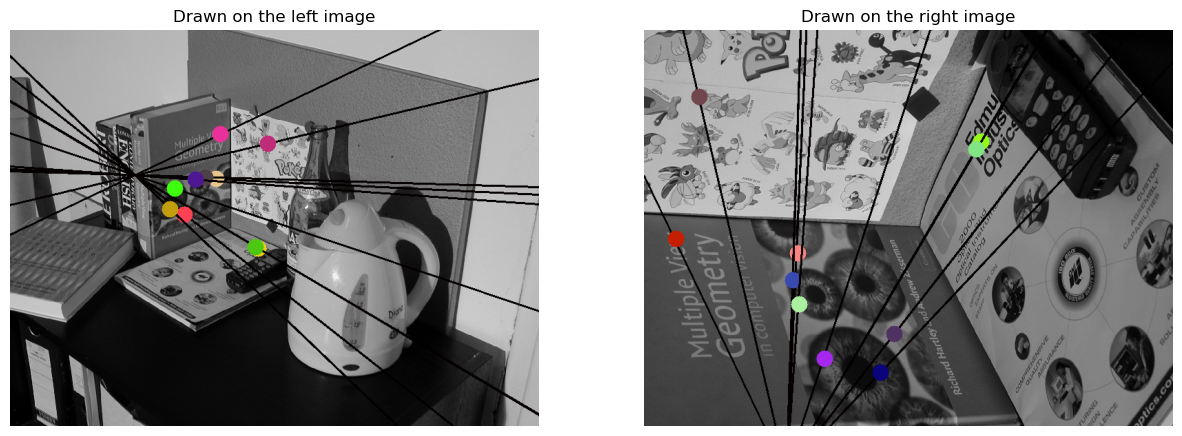

In [129]:
def generate_F(required_points, T_q, T_p, kp1, kp2, good_matches, indices):
    # Constructing matrix
    mat = [[0 for _ in range(9)] for _ in range(required_points)]
    # Use points to generate the matrix, i=row j=column    
    for i in range(required_points):
        p1, p2 = kp1[good_matches[indices[i]].queryIdx].pt
        p_hat = np.dot(T_p, np.array([p1,p2,1]))
        p1 = p_hat[0]
        p2 = p_hat[1]
        q1, q2 = kp2[good_matches[indices[i]].trainIdx].pt
        q_hat = np.dot(T_q, np.array([q1,q2,1]))
        q1 = q_hat[0]
        q2 = q_hat[1]
        mat[i][0] = np.dot(p1, q1)
        mat[i][1] = np.dot(p2, q1)
        mat[i][2] = q1
        mat[i][3] = np.dot(p1, q2)
        mat[i][4] = np.dot(p2, q2)
        mat[i][5] = q2
        mat[i][6] = p1
        mat[i][7] = p2
        mat[i][8] = 1
        rank = np.linalg.matrix_rank(mat)
        
    # Ensure rank of F matrix equals the required 8 points using a tolerance
    rank = np.linalg.matrix_rank(mat)    
    if rank >= 8:
        # Using SVD to compute the null space to find the draft F matrix
        U, s, V = np.linalg.svd(mat, full_matrices = True)
        rank = np.linalg.matrix_rank(mat)
        U, s, V = np.linalg.svd(mat, full_matrices = True)
        t_V_mat = np.transpose(V)
        ncols = t_V_mat.shape[1]
        right_null_mat = t_V_mat[:,-1]

        # Converting nullspace vector to draft 3x3 F matrix
        F_dim = 3
        F_draft = [[0 for _ in range(F_dim)] for _ in range(F_dim)]
        F_draft[0][0] = float(right_null_mat[0])
        F_draft[0][1] = float(right_null_mat[1])
        F_draft[0][2] = float(right_null_mat[2])
        F_draft[1][0] = float(right_null_mat[3])
        F_draft[1][1] = float(right_null_mat[4])
        F_draft[1][2] = float(right_null_mat[5])
        F_draft[2][0] = float(right_null_mat[6])
        F_draft[2][1] = float(right_null_mat[7])
        F_draft[2][2] = float(right_null_mat[8])

        # Perform another SVD of the draft F matrix and zero smallest eigenvalue to form F matrix
        U, s, V = np.linalg.svd(F_draft, full_matrices = True)
        s[np.argmin(s)] = 0
        F_norm = np.dot(np.dot(U,np.diag(s)),V)
        F = np.dot(np.dot(np.transpose(T_q),F_norm),T_p)
        return F



# Calculate transformation for scaling and shifting
p1_all = []
p2_all = []
q1_all = []
q2_all = []
match_num = len(good)
for i in range(match_num):
    p1, p2 = kp1[good[i].queryIdx].pt
    q1, q2 = kp2[good[i].trainIdx].pt
    p1_all.append(p1)
    p2_all.append(p2)
    q1_all.append(q1)
    q2_all.append(q2)

p1_bar = 1/match_num * np.sum(p1_all)
p2_bar = 1/match_num * np.sum(p2_all)
q1_bar = 1/match_num * np.sum(q1_all)
q2_bar = 1/match_num * np.sum(q2_all)

p1_tilde = p1_all - p1_bar
p2_tilde = p2_all - p2_bar
q1_tilde = q1_all - q1_bar
q2_tilde = q2_all - q2_bar

s_p = np.sqrt(2)/np.sqrt((1/match_num * np.sum(np.power(p1_tilde, 2) + np.power(p2_tilde, 2))))
s_q = np.sqrt(2)/np.sqrt((1/match_num * np.sum(np.power(q1_tilde, 2) + np.power(q2_tilde, 2))))


T_p = np.diag([1,1,1])
T_p[0][2] = -p1_bar
T_p[1][2] = -p2_bar
T_p = np.dot(np.diag([s_p,s_p,1]),T_p)

T_q = np.diag([1,1,1])
T_q[0][2] = -q1_bar
T_q[1][2] = -q2_bar
T_q = np.dot(np.diag([s_q,s_q,1]),T_q)

# Calculating number of RANSAC trials required
# Want to find a good F with at least 99% probability
p = 0.99
# Estimated probability that the returned description and matching phases as inliers
w = 0.5
# Number of points sampled
n = 8
# Number of tirals to perform for RANSAC
k = np.log(1-p)/np.log(1-np.power(w, n))
k = np.int32(k)

# Reset for loop
inlier_ratio = 0
F_best = 0
ptsR_best = 0
ptsL_best = 0

for i in range(k):
    # Randomly select 8 unique matching points (unique points can be too close together making it linearly dependent)
    required_points = 8
    assert len(good) >= required_points
    match_indices = []
    for i in range(required_points):
        random_point = random.randint(0,len(good)-1)
        while random_point in match_indices:
            random_point = random.randint(0,len(good)-1)
        match_indices.append(random_point) 
        
    F = generate_F(required_points, T_q, T_p, kp1, kp2, good, match_indices)
    if F is None:
        continue

    # Check performance of the F matrix using remaining correspondence points
    test_matches = np.delete(good, match_indices)
    inlier_count = 0
    ptsL = []
    ptsR = []
    inlier_indices = []
    for i in range(len(test_matches)):
        p1, p2 = kp1[test_matches[i].queryIdx].pt
        p = np.array([p1, p2, 1])
        #p_hat = np.dot(T_p, np.array([p1,p2,1]))
        #p1 = p_hat[0]
        #p2 = p_hat[1]
        q1, q2 = kp2[test_matches[i].trainIdx].pt
        #q_hat = np.dot(T_q, np.array([q1,q2,1]))
        #q1 = q_hat[0]
        #q2 = q_hat[1]
        #epsilon = 0.001
        #if np.dot(np.dot(np.array([q1,q2,1]),F_norm),np.array([p1,p2,1])) < epsilon:
        #    inlier_count = inlier_count+1
        #    ptsL.append(kp1[test_matches[i].queryIdx].pt)
        #    ptsR.append(kp2[test_matches[i].trainIdx].pt)
        p_prime = np.dot(F, p)
        d = np.absolute(p_prime[0]*q1 + p_prime[1]*q2 + p_prime[2])/np.sqrt(p_prime[0]**2 + p_prime[1]**2)
        if d < 2:
            inlier_count = inlier_count+1
            ptsL.append(kp1[test_matches[i].queryIdx].pt)
            ptsR.append(kp2[test_matches[i].trainIdx].pt)
            inlier_indices.append(i)

    if (inlier_count/len(test_matches)) > inlier_ratio:
        inlier_ratio = inlier_count/len(test_matches)
        inlier_count_best = inlier_count
        ptsL_best = ptsL
        ptsR_best = ptsR
        best_inlier_indices = inlier_indices

# Generate best F matrix using all the inliner samples
print(best_inlier_indices)
F = generate_F(len(best_inlier_indices), T_q, T_p, kp1, kp2, good, best_inlier_indices)
assert len(ptsR) == len(ptsL)
ptsR = np.int32(ptsR_best)
ptsL = np.int32(ptsL_best)
indices = random.sample(range(1, len(ptsR)), 10)
ptsR = ptsR[indices]
ptsL = ptsL[indices]


print(np.linalg.det(F))
print(inlier_count_best)
print(inlier_ratio)


# create a function to draw epilines over the images
# Epilines corresponding to the points in first image is drawn on second image
def drawlines(img1,img2,lines,pts1,pts2):
    h, w = imgA.shape
    ''' img1 - image on which we draw the epilines for the points in img2
        lines - corresponding epilines '''
    r,c = img1.shape
    img1 = cv2.cvtColor(img1, cv2.COLOR_GRAY2BGR)
    img2 = cv2.cvtColor(img2, cv2.COLOR_GRAY2BGR)
    for r,pt1,pt2 in zip(lines, pts1, pts2):
        color = tuple(np.random.randint(0,255,3).tolist())
        x0,y0 = map(int, [0, -r[2]/r[1] ])
        x1,y1 = map(int, [c, -(r[2]+r[0]*c)/r[1] ])
        img1 = cv2.line(img1, (x0,y0), (x1,y1), 4, np.int32(h/200))
        img1 = cv2.circle(img1, tuple(pt1), np.int32(h/200), color, 20)
        img2 = cv2.circle(img2, tuple(pt2), np.int32(h/200), color, 20)
    return img1,img2

# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(imgA, imgB, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(imgB, imgA, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 


95
0.7142857142857143


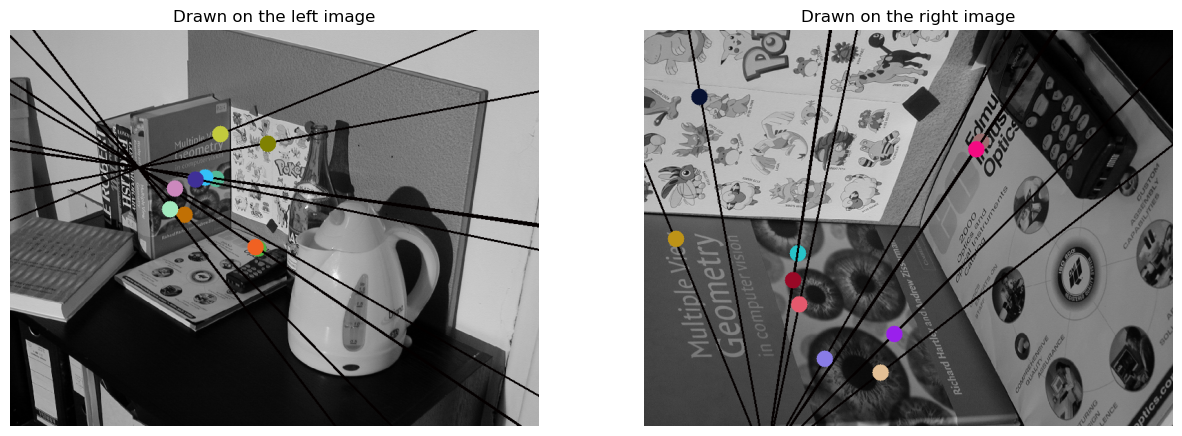

In [130]:
# Comparing with CV2 implementation of caluclating F matrix
pts1 = np.int32(pts1)
pts2 = np.int32(pts2)
F, mask = cv2.findFundamentalMat(pts1,pts2,cv2.FM_LMEDS)
inlier_count = 0
for matches in test_matches:
    p1, p2 = kp1[matches.queryIdx].pt
    p = np.array([p1, p2, 1])
    q1, q2 = kp2[matches.trainIdx].pt
    p_prime = np.dot(F, p)
    d = np.absolute(p_prime[0]*q1 + p_prime[1]*q2 + p_prime[2])/np.sqrt(p_prime[0]**2 + p_prime[1]**2)
    if d < 2:
        inlier_count = inlier_count+1

print(inlier_count)
print(inlier_count/len(test_matches))

# Find epilines corresponding to points in right image 
# and draw its lines on left image
linesL = cv2.computeCorrespondEpilines(ptsR.reshape(-1,1,2), 2, F)
linesL = linesL.reshape(-1,3)
img5, img6 = drawlines(imgA, imgB, linesL, ptsL, ptsR)

# Find epilines corresponding to points in left image 
# and draw its lines on right image
linesR = cv2.computeCorrespondEpilines(ptsL.reshape(-1,1,2), 1, F)
linesR = linesR.reshape(-1,3)
img3, img4 = drawlines(imgB, imgA, linesR, ptsR, ptsL)

# Display the results
plt.subplots(figsize=(15, 15)) 

plt.subplot(1,2,1)
plt.imshow(img5, cmap='gray')  
plt.title('Drawn on the left image')
plt.axis('off')

plt.subplot(1,2,2)
plt.imshow(img3, cmap='gray')  
plt.title('Drawn on the right image')
plt.axis('off')

plt.show() 

### 3. Randomly sample 10 correspondences and display images, corresponding points and epipolar lines

In [116]:
indices

[78, 40, 77, 24, 16, 60, 83, 27, 6, 90]